<a href="https://colab.research.google.com/github/csabiu/ML_tutorial/blob/master/density_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install pyfftw
!pip install powerbox

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import powerbox as pbox
import time
import scipy

In [25]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Input,BatchNormalization, Dropout, Flatten
from tensorflow.keras.layers import AveragePooling3D, Conv3DTranspose
from tensorflow.keras.layers import concatenate, Concatenate

2.7.0


In [26]:
### USE TPU - check menu Runtime -> change runtime type
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.93.150.82:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.93.150.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.93.150.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


### Create a 2D lognormal density field

/usr/local/lib/python3.7/dist-packages/powerbox/powerbox.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gpa = np.abs(dft.fft(gca, L=self.boxlength, a=self.fourier_a, b=self.fourier_b))[0]


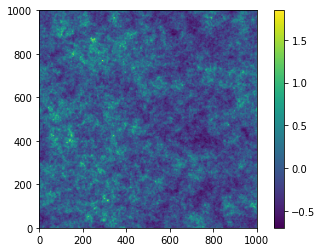

In [5]:
lnpb = pbox.LogNormalPowerBox(
    N=256,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.1*k**-2., # The power-spectrum
    boxlength = 1000.0,           # Size of the box (sets the units of k in pk)
    seed = 1010                # Use the same seed as our powerbox
)
plt.imshow(lnpb.delta_x(),extent=(0,1000,0,1000))
plt.colorbar()
plt.show()

## Create a discrete sampling of the field. 
It looks like it is tracing the above field.

/usr/local/lib/python3.7/dist-packages/powerbox/powerbox.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gpa = np.abs(dft.fft(gca, L=self.boxlength, a=self.fourier_a, b=self.fourier_b))[0]


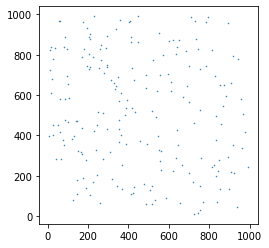

In [10]:
sample=lnpb.create_discrete_sample(nbar=2.0E-4, min_at_zero=True)

#plt.imshow(lnpb.delta_x(),extent=(0,1000,0,1000))
plt.plot(sample[:,0],sample[:,1],'.',markersize=1)
ax=plt.gca()
ax.set_aspect('equal', adjustable='box')

### Create a 3D field, create a discrete Sample, and rebin that sample on a grid

/usr/local/lib/python3.7/dist-packages/powerbox/powerbox.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gpa = np.abs(dft.fft(gca, L=self.boxlength, a=self.fourier_a, b=self.fourier_b))[0]


15.789595603942871


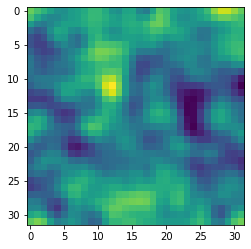

In [27]:
start=time.time()

lnpb = pbox.LogNormalPowerBox(
    N=32,                     # Number of grid-points in the box
    dim=3,                     # 2D box
    pk = lambda k: 0.1*k**-2., # The power-spectrum
    boxlength = 1000.0,           # Size of the box (sets the units of k in pk)
    seed = 1010                # Use the same seed as our powerbox
)

ln_samples = lnpb.create_discrete_sample(nbar=1000.0E-4, min_at_zero=True)

grid,edge=np.histogramdd(ln_samples,range=[(0,1000),(0,1000),(0,1000)],bins=32)
#grid,edge=np.histogramdd(ln_samples,range=[(0,1000),(0,1000)],bins=32)

print(time.time()-start)

plt.imshow(scipy.ndimage.gaussian_filter(lnpb.delta_x()[:,1,:], 1.))

3

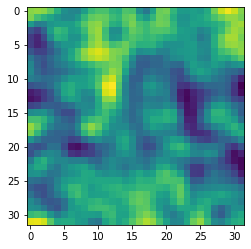

In [44]:
grid2=1.*(grid)
for i in range(32):
  grid2[:,:,i]=grid[:,:,i].T
plt.imshow((scipy.ndimage.gaussian_filter(grid2[:,1,:], 1.)))
#plt.plot(ln_samples[:,0],ln_samples[:,1],',')
grid.ndim

### create N samples 

In [28]:
inputs=[]
outputs=[]
sgrid=32

for i in range(500):
  lnpb = pbox.LogNormalPowerBox(N=sgrid,dim=3,pk = lambda k: 0.1*k**-2.,boxlength = 1000.0,seed = i+1000)
  ln_samples = lnpb.create_discrete_sample(nbar=1.0E-3, min_at_zero=True)
  grid,edge=np.histogramdd(ln_samples,range=[(0,1000),(0,1000),(0,1000)],bins=sgrid)
  #inputs.append(np.transpose(np.log((grid-np.mean(grid))/np.mean(grid))))
  grid2=1.*grid
  for i in range(32):
    grid2[:,:,i]=grid[:,:,i].T
  inputs.append(grid2)
  outputs.append(lnpb.delta_x())


/usr/local/lib/python3.7/dist-packages/powerbox/powerbox.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gpa = np.abs(dft.fft(gca, L=self.boxlength, a=self.fourier_a, b=self.fourier_b))[0]


### Seperate into trainng and testing sets

In [29]:
split=450
test_data=tf.expand_dims(inputs[split:],-1)/10.0
train_data=tf.expand_dims(inputs[:split],-1)/10.0

test_truth=tf.expand_dims(outputs[split:],-1)
train_truth=tf.expand_dims(outputs[:split],-1)

print(np.shape(train_data))
print(np.shape(train_truth))
print(np.shape(test_data))
print(np.shape(test_truth))

(450, 32, 32, 32, 1)
(450, 32, 32, 32, 1)
(50, 32, 32, 32, 1)
(50, 32, 32, 32, 1)


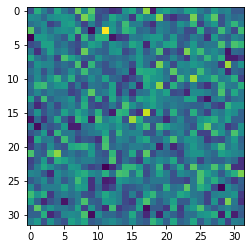

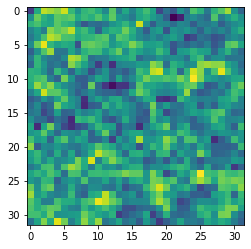

In [8]:
import scipy
plt.imshow(inputs[0][:,:,1])
#plt.imshow(scipy.ndimage.gaussian_filter(inputs[3][:,:,1], 2.))
plt.show()
plt.imshow(outputs[0][:,:,1])
#plt.imshow(scipy.ndimage.gaussian_filter(outputs[3][:,:,1], 2.))
plt.show()

### define tranformers to normalise data (nice 0,1 ranges)

In [30]:
def transform_frw(X,max,min):
  return (X-min)/(max-min)

def transform_back(X,max,min):
  return X*(max-min)+min

max_inputs=np.max(inputs)
min_inputs=np.min(inputs)
max_outputs=np.max(outputs)
min_outputs=np.min(outputs)

### Define U-net architecture

In [53]:
lrelu = 'tanh' #lambda x: tf.keras.activations.elu(x, alpha=0.2)
lrelu_out = lambda x: tf.keras.activations.tanh(x)#,max_value=1.0)
#lrelu='relu'

drop=0.1
def pool(layer):
  #return MaxPooling3D((2, 2, 2))(layer)
  return AveragePooling3D((2, 2,2))(layer)

def build_model(input_layer, start_neurons):
    conv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation=lrelu, padding="same")(input_layer)
    #conv1 = BatchNormalization( )(conv1)
    conv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation=lrelu, padding="same")(conv1)
    #conv1 = BatchNormalization()(conv1)
    pool1 = pool(conv1)
    pool1 = Dropout(drop)(pool1)

    conv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=lrelu, padding="same")(pool1)
    #conv2 = BatchNormalization()(conv2)
    conv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=lrelu, padding="same")(conv2)
    #conv2 = BatchNormalization()(conv2)
    pool2 = pool(conv2)
    pool2 = Dropout(drop)(pool2)

    conv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=lrelu, padding="same")(pool2)
    #conv3 = BatchNormalization()(conv3)
    conv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=lrelu, padding="same")(conv3)
    #conv3 = BatchNormalization()(conv3)
    pool3 = pool(conv3)
    pool3 = Dropout(drop)(pool3)

    conv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation=lrelu, padding="same")(pool3)
    #conv4 = BatchNormalization()(conv4)
    conv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation=lrelu, padding="same")(conv4)
    #conv4 = BatchNormalization()(conv4)
    pool4 = pool(conv4)
    pool4 = Dropout(drop)(pool4)

    # Middle
    convm = Conv3D(start_neurons * 8, (3, 3, 3), activation=lrelu, padding="same")(pool4)
    #convm = BatchNormalization()(convm)
    convm = Conv3D(start_neurons * 8, (3, 3, 3), activation=lrelu, padding="same")(convm)
    #convm = BatchNormalization()(convm)

    deconv4 = Conv3DTranspose(start_neurons * 8, (3, 3, 3), strides=(2, 2,2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    #uconv4 = Dropout(drop)(uconv4)
    uconv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation=lrelu, padding="same")(uconv4)
    #uconv4 = BatchNormalization()(uconv4)
    uconv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation=lrelu, padding="same")(uconv4)
    #uconv4 = BatchNormalization()(uconv4)

    deconv3 = Conv3DTranspose(start_neurons * 4, (3, 3, 3), strides=(2, 2,2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    #uconv3 = Dropout(drop)(uconv3)
    uconv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=lrelu, padding="same")(uconv3)
    #uconv3 = BatchNormalization()(uconv3)
    uconv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=lrelu, padding="same")(uconv3)
    #uconv3 = BatchNormalization()(uconv3)

    deconv2 = Conv3DTranspose(start_neurons * 2, (3, 3, 3), strides=(2, 2,2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(drop)(uconv2)
    uconv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=lrelu, padding="same")(uconv2)
    #uconv2 = BatchNormalization()(uconv2)
    uconv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=lrelu, padding="same")(uconv2)
    #uconv2 = BatchNormalization()(uconv2)

    deconv1 = Conv3DTranspose(start_neurons * 2, (3, 3, 3), strides=(2, 2,2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(drop)(uconv1)
    uconv1 = Conv3D(start_neurons * 2, (3, 3, 3), activation=lrelu, padding="same")(uconv1)
    #uconv1 = BatchNormalization()(uconv1)
    uconv1 = Conv3D(start_neurons * 2, (3, 3, 3), activation=lrelu, padding="same")(uconv1)
    #uconv1 = BatchNormalization()(uconv1)
    
    #output_layer = Conv3D(1, (1,1,1), padding="same", activation="sigmoid")(uconv1)
    #output_layer = Conv3D(1, (1,1,1), padding="same", activation=lrelu_out)(uconv1)
    output_layer = Conv3D(1, (1,1,1), padding="same")(uconv1)
    model=Model(inputs=[input_layer],outputs=[output_layer])
    return model

def customLoss(yTrue,yPred):
    import numpy as np
    import tensorflow.keras.backend as K

    #ndim=K.cast(tf.shape(yTrue)[0], dtype='float')

    yTrueN=yTrue[:,2:30,2:30,2:30,:]
    yPredN=yPred[:,2:30,2:30,2:30,:]
    
    #yTrue=K.cast(yTrue, dtype='float')
    #yPred=K.cast(yPred, dtype='float')
    
    yTrue=K.flatten(yTrue)
    yPred=K.flatten(yPred)

    #yTrue=yTrue[yTrue==yTrue]
    #yPred=yPred[yPred==yPred]

    L=tf.math.reduce_sum((tf.math.log(tf.math.cosh(yTrue - yPred))),axis=-1) #log 
    #L=tf.math.reduce_mean(tf.math.reduce_sum(tf.math.reduce_sum(tf.math.reduce_sum(tf.abs(yTrue-yPred),axis=-1),axis=-1),axis=-1),axis=-1)
    #L=tf.math.reduce_sum(tf.pow((yTrue-yPred),2))
    #L=tf.math.reduce_sum(tf.pow((yTrue-yPred),4))

    return L

img_size_target=32

input_layer = Input((img_size_target, img_size_target,img_size_target, 1))
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model_error = build_model(input_layer, 32)

opt=tf.keras.optimizers.Adam(learning_rate=0.0001)
model_error.compile(optimizer=opt,loss=customLoss)

#model_error.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="mean_squared_error", metrics=["accuracy"])
model_error.summary(line_length=128)


Model: "model_13"
________________________________________________________________________________________________________________________________
 Layer (type)                             Output Shape                Param #        Connected to                               
 input_14 (InputLayer)                    [(None, 32, 32, 32, 1)]     0              []                                         
                                                                                                                                
 conv3d_247 (Conv3D)                      (None, 32, 32, 32, 32)      896            ['input_14[0][0]']                         
                                                                                                                                
 conv3d_248 (Conv3D)                      (None, 32, 32, 32, 32)      27680          ['conv3d_247[0][0]']                       
                                                                               

### Train the model

In [54]:
results = model_error.fit(transform_frw(train_data,min_inputs,max_inputs), transform_frw(train_truth,min_outputs,max_outputs), epochs=30,validation_split=0.1)#,batch_size=160)#,validation_batch_size=5)
#results = model_error.fit(train_data, train_truth, validation_split=0.1, epochs=30,batch_size=20)#,validation_batch_size=5)
#results = model_error.fit(transform_frw(train_data,min_inputs,max_inputs), transform_frw(train_truth,min_outputs,max_outputs), epochs=30, validation_split=0.9,batch_size=35)

Epoch 1/30
13/13 [==============================] - 93s 5s/step - loss: 2990.5928 - val_loss: 1132.1029
Epoch 2/30
13/13 [==============================] - 2s 173ms/step - loss: 1293.0706 - val_loss: 713.6583
Epoch 3/30
13/13 [==============================] - 2s 172ms/step - loss: 914.6654 - val_loss: 542.3773
Epoch 4/30
13/13 [==============================] - 2s 169ms/step - loss: 809.0686 - val_loss: 532.9593
Epoch 5/30
13/13 [==============================] - 2s 167ms/step - loss: 765.7305 - val_loss: 523.5108
Epoch 6/30
13/13 [==============================] - 2s 170ms/step - loss: 735.3104 - val_loss: 517.9217
Epoch 7/30
13/13 [==============================] - 2s 170ms/step - loss: 711.4664 - val_loss: 514.0699
Epoch 8/30
13/13 [==============================] - 2s 169ms/step - loss: 691.1913 - val_loss: 511.3353
Epoch 9/30
13/13 [==============================] - 2s 171ms/step - loss: 674.8866 - val_loss: 507.5533
Epoch 10/30
13/13 [==============================] - 2s 168ms/s

### Plot the learning rate

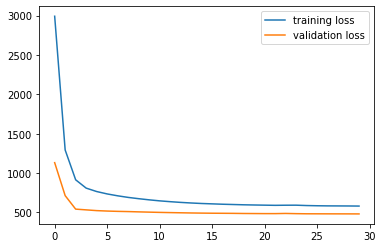

In [55]:
plt.plot(results.history['loss'],label='training loss')
plt.plot(results.history['val_loss'],label='validation loss')
plt.legend()

### Make a prediction from trained model
remembering to transform the data forward and then backwards (normalisation)

In [56]:
preds = transform_back(model_error.predict(transform_frw(test_data,min_inputs,max_inputs), verbose=1),min_outputs,max_outputs)
#preds = model_error.predict(test_data, verbose=1)

2/2 [==============================] - 46s 45s/step


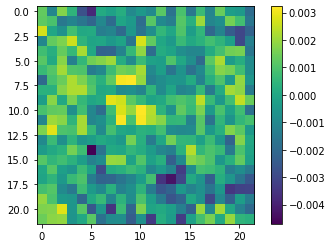

In [57]:
plt.imshow(preds[1,10,5:-5,5:-5,0])
plt.colorbar()

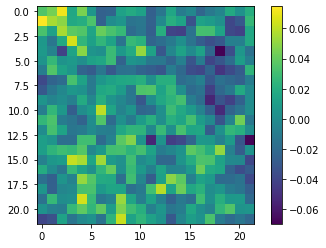

In [58]:
plt.imshow(test_truth[1,10,5:-5,5:-5,0])
plt.colorbar()

In [32]:
lrelu = lambda x: tf.keras.activations.elu(x, alpha=0.2)
lrelu_out = lambda x: tf.keras.activations.tanh(x)#,max_value=1.0)
#lrelu='relu'

drop=0.1
def pool(layer):
  #return MaxPooling3D((2, 2, 2))(layer)
  return AveragePooling3D((2, 2,2))(layer)

def build_model(input_layer, start_neurons):
    conv1 = Conv3D(start_neurons * 3, (3, 3, 3), activation=lrelu, padding="same")(input_layer)
    #conv1 = BatchNormalization()(conv1)
    conv1 = Conv3D(start_neurons * 3, (3, 3, 3), activation=lrelu, padding="same")(conv1)
    conv1 = Dropout(drop)(conv1)
    conv1 = Conv3D(start_neurons * 3, (3, 3, 3), activation=lrelu, padding="same")(conv1)
    conv1 = Dropout(drop)(conv1)
    conv1 = Conv3D(start_neurons * 3, (3, 3, 3), activation=lrelu, padding="same")(conv1)
    #conv1 = Dropout(drop)(conv1)
    #conv1 = Conv3D(start_neurons * 4, (3, 3, 3), activation=lrelu, padding="same")(conv1)

    #output_layer = Conv3D(1, (1,1,1), padding="same", activation="sigmoid")(conv1)
    #output_layer = Conv3D(1, (1,1,1), padding="same", activation=lrelu_out)(conv1)
    output_layer = Conv3D(1, (1,1,1), padding="same")(conv1)
    model=Model(inputs=[input_layer],outputs=[output_layer])
    return model

def customLoss(yTrue,yPred):
    import numpy as np
    import tensorflow.keras.backend as K

    #yTrueN=yTrue[:,4:60,4:60,4:60,:]
    #yPredN=yPred[:,4:60,4:60,4:60,:]

    yTrueN=yTrue[:,2:30,2:30,2:30,:]
    yPredN=yPred[:,2:30,2:30,2:30,:]
    
    yTrue=K.cast(yTrue, dtype='float')
    yPred=K.cast(yPred, dtype='float')
    
    yTrue=K.flatten(yTrue)
    yPred=K.flatten(yPred)


    #L=tf.math.reduce_sum((tf.math.log(tf.math.cosh(yTrue - yPred)))) #log 
    #L=tf.math.reduce_sum(tf.abs(yTrue-yPred))
    #L=tf.math.reduce_sum(tf.pow((yTrue-yPred),2))
    L=tf.math.reduce_sum(tf.pow((yTrue-yPred),4))

    return L

img_size_target=32

input_layer = Input((img_size_target, img_size_target,img_size_target, 1))
#with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
model_error = build_model(input_layer, 32)

opt=tf.keras.optimizers.Adam(learning_rate=0.0001)
model_error.compile(optimizer=opt,loss=customLoss)

#model_error.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss="mean_squared_error", metrics=["accuracy"])
model_error.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 32, 1)]   0         
                                                                 
 conv3d_27 (Conv3D)          (None, 32, 32, 32, 96)    2688      
                                                                 
 conv3d_28 (Conv3D)          (None, 32, 32, 32, 96)    248928    
                                                                 
 dropout_8 (Dropout)         (None, 32, 32, 32, 96)    0         
                                                                 
 conv3d_29 (Conv3D)          (None, 32, 32, 32, 96)    248928    
                                                                 
 dropout_9 (Dropout)         (None, 32, 32, 32, 96)    0         
                                                                 
 conv3d_30 (Conv3D)          (None, 32, 32, 32, 96)    2489

In [37]:
#results = model_error.fit(train_data, train_truth, validation_split=0.1, epochs=30,batch_size=20)#,validation_batch_size=5)
results = model_error.fit(transform_frw(train_data,min_inputs,max_inputs), transform_frw(train_truth,min_outputs,max_outputs), epochs=30, validation_split=0.1,batch_size=20)#,validation_batch_size=5)


Epoch 1/30
21/21 [==============================] - 66s 3s/step - loss: 13132.9404 - val_loss: 2535.4927
Epoch 2/30
21/21 [==============================] - 66s 3s/step - loss: 1369.4316 - val_loss: 2052.8025
Epoch 3/30
21/21 [==============================] - 66s 3s/step - loss: 771.8544 - val_loss: 2017.0497
Epoch 4/30
21/21 [==============================] - 66s 3s/step - loss: 483.1096 - val_loss: 2402.5742
Epoch 5/30
21/21 [==============================] - 66s 3s/step - loss: 304.0499 - val_loss: 3694.6951
Epoch 6/30
21/21 [==============================] - 66s 3s/step - loss: 227.1180 - val_loss: 4283.4468
Epoch 7/30
21/21 [==============================] - 65s 3s/step - loss: 201.0369 - val_loss: 4358.0737
Epoch 8/30
21/21 [==============================] - 66s 3s/step - loss: 189.3815 - val_loss: 4380.7886
Epoch 9/30
21/21 [==============================] - 66s 3s/step - loss: 183.1859 - val_loss: 4352.3633
Epoch 10/30
21/21 [==============================] - 66s 3s/step - los

KeyboardInterrupt: ignored

2/2 [==============================] - 1s 1s/step


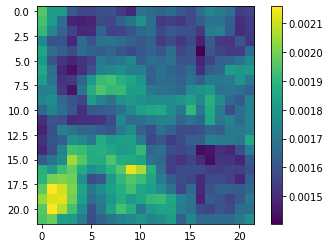

In [40]:
preds = transform_back(model_error.predict(transform_frw(test_data,min_inputs,max_inputs), verbose=1),min_outputs,max_outputs)
plt.imshow(preds[1,10,5:-5,5:-5,0])
plt.colorbar()

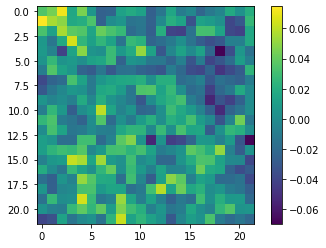

In [35]:
plt.imshow(test_truth[1,10,5:-5,5:-5,0])
plt.colorbar()

In [45]:
np.shape(inputs)
inputs[1][1,:,:]

array([[6., 2., 2., ..., 5., 0., 3.],
       [3., 3., 2., ..., 7., 1., 3.],
       [5., 5., 1., ..., 7., 3., 3.],
       ...,
       [3., 3., 1., ..., 4., 1., 8.],
       [3., 4., 6., ..., 1., 2., 6.],
       [3., 2., 1., ..., 2., 5., 4.]])